<a href="https://colab.research.google.com/github/ShagunSharma98/Beer-Customer_Reviews-Analysis/blob/main/Customer%20Review%20Attribute%20Extraction%20and%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
import itertools
import spacy
from tqdm.notebook import tqdm as tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

!pip3 install sentence_transformers
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
stop_words = list(set(stopwords.words("english")))
# stop_words+=['beer','drink','like','make', 'nice', 'bit']
stop_words+=['beer','drink','like','make', 'nice', 'bit', 'little',
             'bad', 'still', 'way', 'fantastic', 'mike', 'think', 
             'really', 'excellent', 'drinker', 'go','pour', 'high',
             'get', 'th', 'also', 'ever', 'absolutely', 'could', 'top', 'want', 'better', 'give']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pd.set_option('display.max_rows', None)
data = pd.read_excel('/content/drive/MyDrive/Raw_Data.xlsx', sheet_name='Raw Data')
tax = pd.read_excel('/content/drive/MyDrive/Raw_Data.xlsx', sheet_name='Taxonomy')
data.head()

id                                            content                 date  \
0   1  Super super sweet . It is like drinking sugar ...  2021-06-21 00:13:00   
1   2  Never a bad choice . While this is not my favo...  2019-10-12 01:28:00   
2   3  I enjoy Rolling Rock on a super hot summer day...  2018-06-24 18:06:00   
3   4  Our go to beer at home ! We always pick up a p...  2017-05-05 10:32:00   
4   6  The flavor is great and the after taste is bet...  2017-01-14 05:18:00   

                                             product         brand  rating  
0      beverage-bud-light-lime-water-melon-rita-malt     Budweiser     2.0  
1                             goose-island-goose-ipa  Goose Island     4.0  
2   rolling-rock-extra-pale-beer-6pk12-fl-oz-bottles  Rolling Rock     5.0  
3                                       corona-extra        Corona     5.0  
4  coors-non-alcoholic-malt-beverage-beer-6pk12-f...         Coors     4.0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9185 entries, 0 to 9184
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       9185 non-null   int64  
 1   content  9185 non-null   object 
 2   date     9185 non-null   object 
 3   product  9183 non-null   object 
 4   brand    8988 non-null   object 
 5   rating   9185 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 430.7+ KB


In [ ]:
df=data.copy()
df['review_date'] = pd.to_datetime(df['date'])
df.head()

id                                            content                 date  \
0   1  Super super sweet . It is like drinking sugar ...  2021-06-21 00:13:00   
1   2  Never a bad choice . While this is not my favo...  2019-10-12 01:28:00   
2   3  I enjoy Rolling Rock on a super hot summer day...  2018-06-24 18:06:00   
3   4  Our go to beer at home ! We always pick up a p...  2017-05-05 10:32:00   
4   6  The flavor is great and the after taste is bet...  2017-01-14 05:18:00   

                                             product         brand  rating  \
0      beverage-bud-light-lime-water-melon-rita-malt     Budweiser     2.0   
1                             goose-island-goose-ipa  Goose Island     4.0   
2   rolling-rock-extra-pale-beer-6pk12-fl-oz-bottles  Rolling Rock     5.0   
3                                       corona-extra        Corona     5.0   
4  coors-non-alcoholic-malt-beverage-beer-6pk12-f...         Coors     4.0   

          review_date  
0 2021-06-21 00:13:00  
1 2019-10-12 01:28:00  
2 2018-06-24 18:06:00  
3 2017-05-05 10:32:00  
4 2017-01-14 05:18:00

In [ ]:
class BeerReviewKeywords:

  # Cleaning the data to remove 
  
    def clean_text(self, text):
      text = text.lower()
      text = re.sub(r"what's", "what is ", text)
      text = re.sub(r"\'s", " ", text)
      text = re.sub(r"\'ve", " have ", text)
      text = re.sub(r"can't", "can not ", text)
      text = re.sub(r"n't", " not ", text)
      text = re.sub(r"i'm", "i am ", text)
      text = re.sub(r"\'re", " are ", text)
      text = re.sub(r"\'d", " would ", text)
      text = re.sub(r"\'ll", " will ", text)
      text = re.sub(r"\'scuse", " excuse ", text)
      text = re.sub('\W', ' ', text)
      text = re.sub('\s+', ' ', text)
      text = text.strip(' ')
      
      return text

    # Method to preprocess the data

    def preprocess(self,data,stopwords):
        # Preprocessing Texts
        preprocessed_texts = []

        lem = WordNetLemmatizer()
    # Cleaing the data, removing stopwords

        for sent in data:
            sent = sent.replace('\\r', ' ')
            sent = sent.replace('\\"', ' ')
            sent = sent.replace('\\n', ' ')
            sent = re.sub('[^A-Za-z ]+', ' ', sent)

            # lemmatizing
            
            sent=' '.join(lem.lemmatize(word) for word in sent.split() if word not in stopwords)
            preprocessed_texts.append(sent.lower().strip())

        return preprocessed_texts
    
    def max_sum_sim(self,doc_embedding, candidate_embeddings, candidates, top_n, nr_candidates):
        # Calculate distances and extract keywords
        distances = cosine_similarity(doc_embedding, candidate_embeddings)
        distances_candidates = cosine_similarity(candidate_embeddings, 
                                            candidate_embeddings)

        # Get top_n words as candidates based on cosine similarity

        words_idx = list(distances.argsort()[0][-nr_candidates:])
        words_vals = [candidates[index] for index in words_idx]
        distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]

        # Calculate the combination of words that are the least similar to each other

        min_sim = np.inf
        candidate = None
        for combination in itertools.combinations(range(len(words_idx)), top_n):
            sim = sum([distances_candidates[i][j] for i in combination for j in combination if i != j])
            if sim < min_sim:
                candidate = combination
                min_sim = sim
        return [words_vals[idx] for idx in candidate]

    # Diversify the keywords using max sum similarity, higher the value of nr_candidates higher the diversity

    def extract_keywords_bert_diverse(self,doc,stopwords,top_n=10,nr_candidates=20):
        n_gram_range = (1,1)
        # Extract candidate words/phrases using count vectorizer (TF-IDF Scores)
        count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([doc])
        # candidates = count.get_feature_names()
        candidates = count.get_feature_names_out()

        # Embeddings of the document using Bert    
        model = SentenceTransformer('distilbert-base-nli-mean-tokens')
        doc_embedding = model.encode([doc])
        candidate_embeddings = model.encode(candidates)
        keywords=self.max_sum_sim(doc_embedding, candidate_embeddings, candidates, top_n, nr_candidates)
        return keywords 

    # Method to get the trending keywords

    def get_trending_keywords(self,data,num_keywords=5):

        # Stopwords
        positive_reviews=data[data['review_sentiments']==1]
        negative_reviews=data[data['review_sentiments']==3]
        neutral_reviews=data[data['review_sentiments']==2]
        processed_text_neg=self.preprocess(negative_reviews['content'].values,stop_words)
        processed_text_pos=self.preprocess(positive_reviews['content'].values,stop_words)
        processed_text_neu=self.preprocess(neutral_reviews['content'].values,stop_words)  
        keywords={}
        corpus=' '.join(processed_text_pos[-500::])
        keywords['positive']=self.extract_keywords_bert_diverse(corpus,stop_words,num_keywords)
        corpus=' '.join(processed_text_neg[-500::])
        keywords['negative']=self.extract_keywords_bert_diverse(corpus,stop_words,num_keywords)
        return keywords
    

    def get_bow(df,d,range_min=1,range_max=1,mindf=0.15,maxdf=1.0):
      """Returns the count vectorized dataframe based on the arguments
      param df(dataframe): dataframe containing the values
      param  d(str): the column name, under which the documents are present
      param range_min(int): smallest n of n-gram wanted
      param range_max(int): largest n of n-gram wanted
      param mindf(int): threshold for common words
      param maxdf(int): threshold for rare words
    
      return cv(CountVectorizer): the count vectorizer
             cv_df(dataframe): dataframe containing the bag of words"""
    
      cv = CountVectorizer(ngram_range=(range_min,range_max),min_df=mindf, max_df=maxdf)
      text_counts = cv.fit_transform(df[d])
      cv_df = pd.DataFrame(text_counts.toarray(), columns = cv.get_feature_names())
      return cv,cv_df
    
    def make_keywords(self, data, column):
      frame=[]
      prep = self.preprocess(data[str(column)],stop_words)
      for item in prep:
        frame.append(item.split())
      return frame
      

# Solution 2

In [ ]:
br = BeerReviewKeywords()

df['comment_text'] = df['content'].map(lambda x : br.clean_text(x))
df['keywords'] = pd.Series(br.make_keywords(data=df, column='comment_text'))

df.head()

id                                            content                 date  \
0   1  Super super sweet . It is like drinking sugar ...  2021-06-21 00:13:00   
1   2  Never a bad choice . While this is not my favo...  2019-10-12 01:28:00   
2   3  I enjoy Rolling Rock on a super hot summer day...  2018-06-24 18:06:00   
3   4  Our go to beer at home ! We always pick up a p...  2017-05-05 10:32:00   
4   6  The flavor is great and the after taste is bet...  2017-01-14 05:18:00   

                                             product         brand  rating  \
0      beverage-bud-light-lime-water-melon-rita-malt     Budweiser     2.0   
1                             goose-island-goose-ipa  Goose Island     4.0   
2   rolling-rock-extra-pale-beer-6pk12-fl-oz-bottles  Rolling Rock     5.0   
3                                       corona-extra        Corona     5.0   
4  coors-non-alcoholic-malt-beverage-beer-6pk12-f...         Coors     4.0   

          review_date                                       comment_text  \
0 2021-06-21 00:13:00  super super sweet it is like drinking sugar on...   
1 2019-10-12 01:28:00  never a bad choice while this is not my favori...   
2 2018-06-24 18:06:00  i enjoy rolling rock on a super hot summer day...   
3 2017-05-05 10:32:00  our go to beer at home we always pick up a pac...   
4 2017-01-14 05:18:00  the flavor is great and the after taste is bet...   

                                            keywords  
0  [super, super, sweet, drinking, sugar, good, t...  
1  [never, choice, favorite, widely, distributed,...  
2  [enjoy, rolling, rock, super, hot, summer, day...  
3  [home, always, pick, pack, corona, grocery, st...  
4  [flavor, great, taste, drinking, beach, bonfir...

In [ ]:
# Load the taxonomy for labelling the data

def taxonomy(taxonomy_data):
  taxo = pd.DataFrame(columns=['Attribute', 'Keywords'])
  for col in set(taxonomy_data['Attribute Type']):
    val = ' '.join(taxonomy_data.loc[tax['Attribute Type']==col]['Keyword'])
    taxo.loc[len(taxo.index)] = [col, list(set(word_tokenize(val.lower())))]
  return taxo

t = taxonomy(tax)

t.head()

Attribute                                           Keywords
0          Packaging  [packaging, capped, brassy, bottle, honey, att...
1            Acidity                          [bitter, acidity, flavor]
2  Temperature State  [ashy, bad, beer, way, icy, tooo, frosty, styl...
3        Ingredients  [bit, dextrin, tea, wheat, barley, malted, ric...
4         Appearance  [laced, :, lace, coffee, yale, color, faded, a...

In [ ]:
# Assigning labels to the review data based on the words present in the reviews

def assign_Attributes(argument):
  attr = []
  for i, j in enumerate(t['Keywords']):
    for word in argument.split():
      if word in j:
        attr.append(t['Attribute'][i])
  return list(set(attr))

df['labels']=df['content'].apply(assign_Attributes)

In [ ]:
multilabel = MultiLabelBinarizer()

y=multilabel.fit_transform(df['labels'])

multilabel.classes_

array(['Acidity', 'Alcohol Content', 'Appearance', 'Aroma', 'Beer Style',
       'Brewing Process', 'Flavor', 'Ingredients', 'Nutritional Content',
       'Packaging', 'Palate', 'Price', 'Temperature State'], dtype=object)

In [ ]:
labels = pd.DataFrame(data=y, columns=multilabel.classes_)
labels.head()

Acidity  Alcohol Content  Appearance  Aroma  Beer Style  Brewing Process  \
0        0                0           0      0           0                0   
1        0                0           0      0           0                0   
2        0                0           0      0           0                1   
3        0                0           0      0           1                1   
4        1                0           0      0           0                0   

   Flavor  Ingredients  Nutritional Content  Packaging  Palate  Price  \
0       0            0                    0          0       1      0   
1       0            0                    0          0       0      0   
2       0            0                    0          0       1      1   
3       0            0                    0          0       1      1   
4       1            0                    0          0       0      0   

   Temperature State  
0                  0  
1                  1  
2                  1  
3                  1  
4                  0

In [ ]:
categories = labels.columns

X_train, X_test, y_train, y_test = train_test_split(df['keywords'].apply(lambda x: ' '.join(x)), labels, test_size=0.2, random_state=0)

In [ ]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

nb_res = {}

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    nb_res[str(category)] = prediction

... Processing Acidity
Test accuracy is 0.6690255851932498
... Processing Alcohol Content
Test accuracy is 0.8100163309744148
... Processing Appearance
Test accuracy is 0.8709853021230267
... Processing Aroma
Test accuracy is 0.7158410451823626
... Processing Beer Style
Test accuracy is 0.7904191616766467
... Processing Brewing Process
Test accuracy is 0.617855198693522
... Processing Flavor
Test accuracy is 0.6358192705498095
... Processing Ingredients
Test accuracy is 0.7915078933043005
... Processing Nutritional Content
Test accuracy is 0.8666303756124115
... Processing Packaging
Test accuracy is 0.7321720195971693
... Processing Palate
Test accuracy is 0.7876973326075123
... Processing Price
Test accuracy is 0.5890038105606968
... Processing Temperature State
Test accuracy is 0.6592270005443658


In [ ]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

svc_res = {}

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    svc_res[str(category)] = prediction

... Processing Acidity
Test accuracy is 0.8677191072400653
... Processing Alcohol Content
Test accuracy is 0.9265106151333696
... Processing Appearance
Test accuracy is 0.954817637452368
... Processing Aroma
Test accuracy is 0.7778987479586282
... Processing Beer Style
Test accuracy is 0.8170930865541643
... Processing Brewing Process
Test accuracy is 0.7457811649428416
... Processing Flavor
Test accuracy is 0.8508437670114317
... Processing Ingredients
Test accuracy is 0.8437670114316821
... Processing Nutritional Content
Test accuracy is 0.9613500272182907
... Processing Packaging
Test accuracy is 0.9368535655960806
... Processing Palate
Test accuracy is 0.8100163309744148
... Processing Price
Test accuracy is 0.633097441480675
... Processing Temperature State
Test accuracy is 0.6788241698421339


In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

log_res={}

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    log_res[str(category)] = prediction

... Processing Acidity
Test accuracy is 0.8459444746869896
... Processing Alcohol Content
Test accuracy is 0.9036472509526402
... Processing Appearance
Test accuracy is 0.9319542732716385
... Processing Aroma
Test accuracy is 0.7964071856287425
... Processing Beer Style
Test accuracy is 0.8214480130647795
... Processing Brewing Process
Test accuracy is 0.7419706042460533
... Processing Flavor
Test accuracy is 0.8530212302667393
... Processing Ingredients
Test accuracy is 0.8399564507348939
... Processing Nutritional Content
Test accuracy is 0.9188894937397931
... Processing Packaging
Test accuracy is 0.9227000544365814
... Processing Palate
Test accuracy is 0.7964071856287425
... Processing Price
Test accuracy is 0.6450734893848666
... Processing Temperature State
Test accuracy is 0.6962438758845945


Based on the accuracies of the above trained models, we will pick SVC for our predictions as it had better accuracy compared to other two

In [ ]:
# Choosing the SVC model and re-training it on the entire data to get better predictions

svc_res_fin = {}

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(df['keywords'].apply(lambda x: ' '.join(x)), labels[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(df['keywords'].apply(lambda x: ' '.join(x)))
    print('Test accuracy is {}'.format(accuracy_score(labels[category], prediction)))
    svc_res_fin[str(category)] = prediction

... Processing Acidity
Test accuracy is 0.9804028307022319
... Processing Alcohol Content
Test accuracy is 0.9913990201415351
... Processing Appearance
Test accuracy is 0.9974959172563963
... Processing Aroma
Test accuracy is 0.9444746869896571
... Processing Beer Style
Test accuracy is 0.9604790419161676
... Processing Brewing Process
Test accuracy is 0.9420794774088187
... Processing Flavor
Test accuracy is 0.9712574850299401
... Processing Ingredients
Test accuracy is 0.9473053892215569
... Processing Nutritional Content
Test accuracy is 0.9885683179096353
... Processing Packaging
Test accuracy is 0.9928143712574851
... Processing Palate
Test accuracy is 0.9647250952640174
... Processing Price
Test accuracy is 0.914534567229178
... Processing Temperature State
Test accuracy is 0.9199782253674469


In [ ]:
feature_names = SVC_pipeline.named_steps["tfidf"].get_feature_names()
coefs = SVC_pipeline.named_steps["clf"].coef_.flatten()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 0, 'Feature Name')

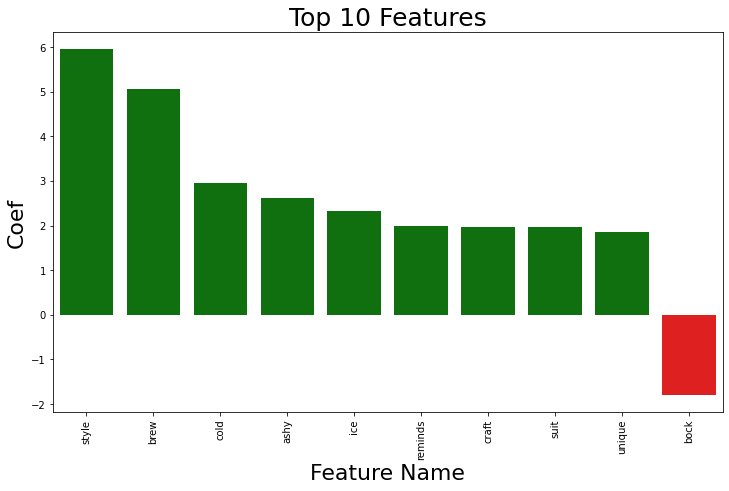

In [ ]:
zipped = zip(feature_names, coefs)

attr = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
attr["abs_value"] = attr["value"].apply(lambda x: abs(x))
attr["colors"] = attr["value"].apply(lambda x: "green" if x > 0 else "red")
attr = attr.sort_values("abs_value", ascending=False)


fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=attr.head(10),
           palette=attr.head(10)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_title("Top 10 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

In [ ]:
res = pd.DataFrame(svc_res_fin)

preds= multilabel.inverse_transform(np.asarray(res))

ss29672_attributes = pd.DataFrame(columns=['id', 'attributes'])
ss29672_attributes['id'] = range(1, len(data)+1)
ss29672_attributes['attributes'] = pd.Series(preds).apply(lambda x: ', '.join(x))

ss29672_attributes.head()

id                                         attributes
0   1                                             Palate
1   2                          Palate, Temperature State
2   3  Brewing Process, Palate, Price, Temperature State
3   4         Brewing Process, Palate, Temperature State
4   5                                    Acidity, Flavor

In [ ]:
ss29672_top10 = pd.DataFrame(columns = ['top10'])
ss29672_top10['top10'] = attr['feature'][:10]

ss29672_top10

top10
11738    style
1647      brew
2589      cold
660       ashy
6082       ice
10026  reminds
2977     craft
11816     suit
12874   unique
1426      bock

In [ ]:
ss29672_attributes.to_csv('/content/drive/MyDrive/ADS Hackathon/ss29672_attributes.csv', index=False)
ss29672_top10.to_csv('/content/drive/MyDrive/ADS Hackathon/ss29672_top10.csv', index=False)

# Solution 1

In [ ]:
br = BeerReviewKeywords()
df['processed_text'] = br.preprocess(df['content'], stopwords=stop_words)
vectors, vectors_name=br.get_bow(df=df, d='processed_text')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
search_params = {'n_components': [5, 10, 15, 20], 'learning_decay': [.5, .7, .9]}

# Initialize the Model
lda = LatentDirichletAllocation()

# Initiliaze Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(vectors_name)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 10, 15, 20]})

In [ ]:
# Estimators for LDA model
lda_model1 = model.best_estimator_
print("Best LDA model's params" , model.best_params_)
print("Best log likelihood Score for the LDA model",model.best_score_)
print("LDA model Perplexity on train data", lda_model1.perplexity(vectors_name))

Best LDA model's params {'learning_decay': 0.9, 'n_components': 5}
Best log likelihood Score for the LDA model -45093.999198439895
LDA model Perplexity on train data 26.772407998144356


In [ ]:
n_topics = 15
learning_decay = 0.9
model_lda = LatentDirichletAllocation(n_components=n_topics,random_state=0, learning_decay=learning_decay)
model_lda.fit(vectors_name)

LatentDirichletAllocation(learning_decay=0.9, n_components=15, random_state=0)

In [ ]:
vectors_name.head()

aroma  bitter  body  bottle  brown  caramel  carbonation  color  dark  \
0      0       0     0       0      0        0            0      0     0   
1      0       0     0       0      0        0            0      0     0   
2      0       0     0       0      0        0            0      0     0   
3      0       0     0       0      0        0            0      0     0   
4      0       0     0       0      0        0            0      0     0   

   finish  ...  hops  light  malt  medium  one  pours  sweet  taste  the  \
0       0  ...     0      0     0       0    0      0      1      0    0   
1       0  ...     0      0     0       0    0      0      0      0    0   
2       0  ...     0      1     0       0    0      0      0      0    0   
3       0  ...     0      0     0       0    0      0      0      0    0   
4       0  ...     0      0     0       0    0      0      0      1    1   

   white  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 23 columns]

In [ ]:
cv, frame = br.get_bow(df=df, d='processed_text')
feature_names = cv.get_feature_names()

topic_result = model_lda.transform(vectors_name)
df['topic']  = topic_result.argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df['attribute'] = df['topic'].apply(lambda x: feature_names[x])

In [ ]:
df.head()

id                                            content                 date  \
0   1  Super super sweet . It is like drinking sugar ...  2021-06-21 00:13:00   
1   2  Never a bad choice . While this is not my favo...  2019-10-12 01:28:00   
2   3  I enjoy Rolling Rock on a super hot summer day...  2018-06-24 18:06:00   
3   4  Our go to beer at home ! We always pick up a p...  2017-05-05 10:32:00   
4   6  The flavor is great and the after taste is bet...  2017-01-14 05:18:00   

                                             product         brand  rating  \
0      beverage-bud-light-lime-water-melon-rita-malt     Budweiser     2.0   
1                             goose-island-goose-ipa  Goose Island     4.0   
2   rolling-rock-extra-pale-beer-6pk12-fl-oz-bottles  Rolling Rock     5.0   
3                                       corona-extra        Corona     5.0   
4  coors-non-alcoholic-malt-beverage-beer-6pk12-f...         Coors     4.0   

          review_date                                     processed_text  \
0 2021-06-21 00:13:00  super super sweet it drinking sugar only good ...   
1 2019-10-12 01:28:00  never bad choice while favorite widely distrib...   
2 2018-06-24 18:06:00  i enjoy rolling rock super hot summer day this...   
3 2017-05-05 10:32:00  our go home we always pick pack corona grocery...   
4 2017-01-14 05:18:00  the flavor great taste better it drinking beac...   

   topic attribute  
0     13      hops  
1     13      hops  
2      0     aroma  
3      0     aroma  
4     13      hops

In [ ]:
df['attribute'].unique()

array(['hops', 'aroma', 'bitter', 'dark', 'brown', 'carbonation',
       'bottle', 'finish', 'caramel', 'body', 'head', 'light', 'flavor',
       'color', 'good'], dtype=object)

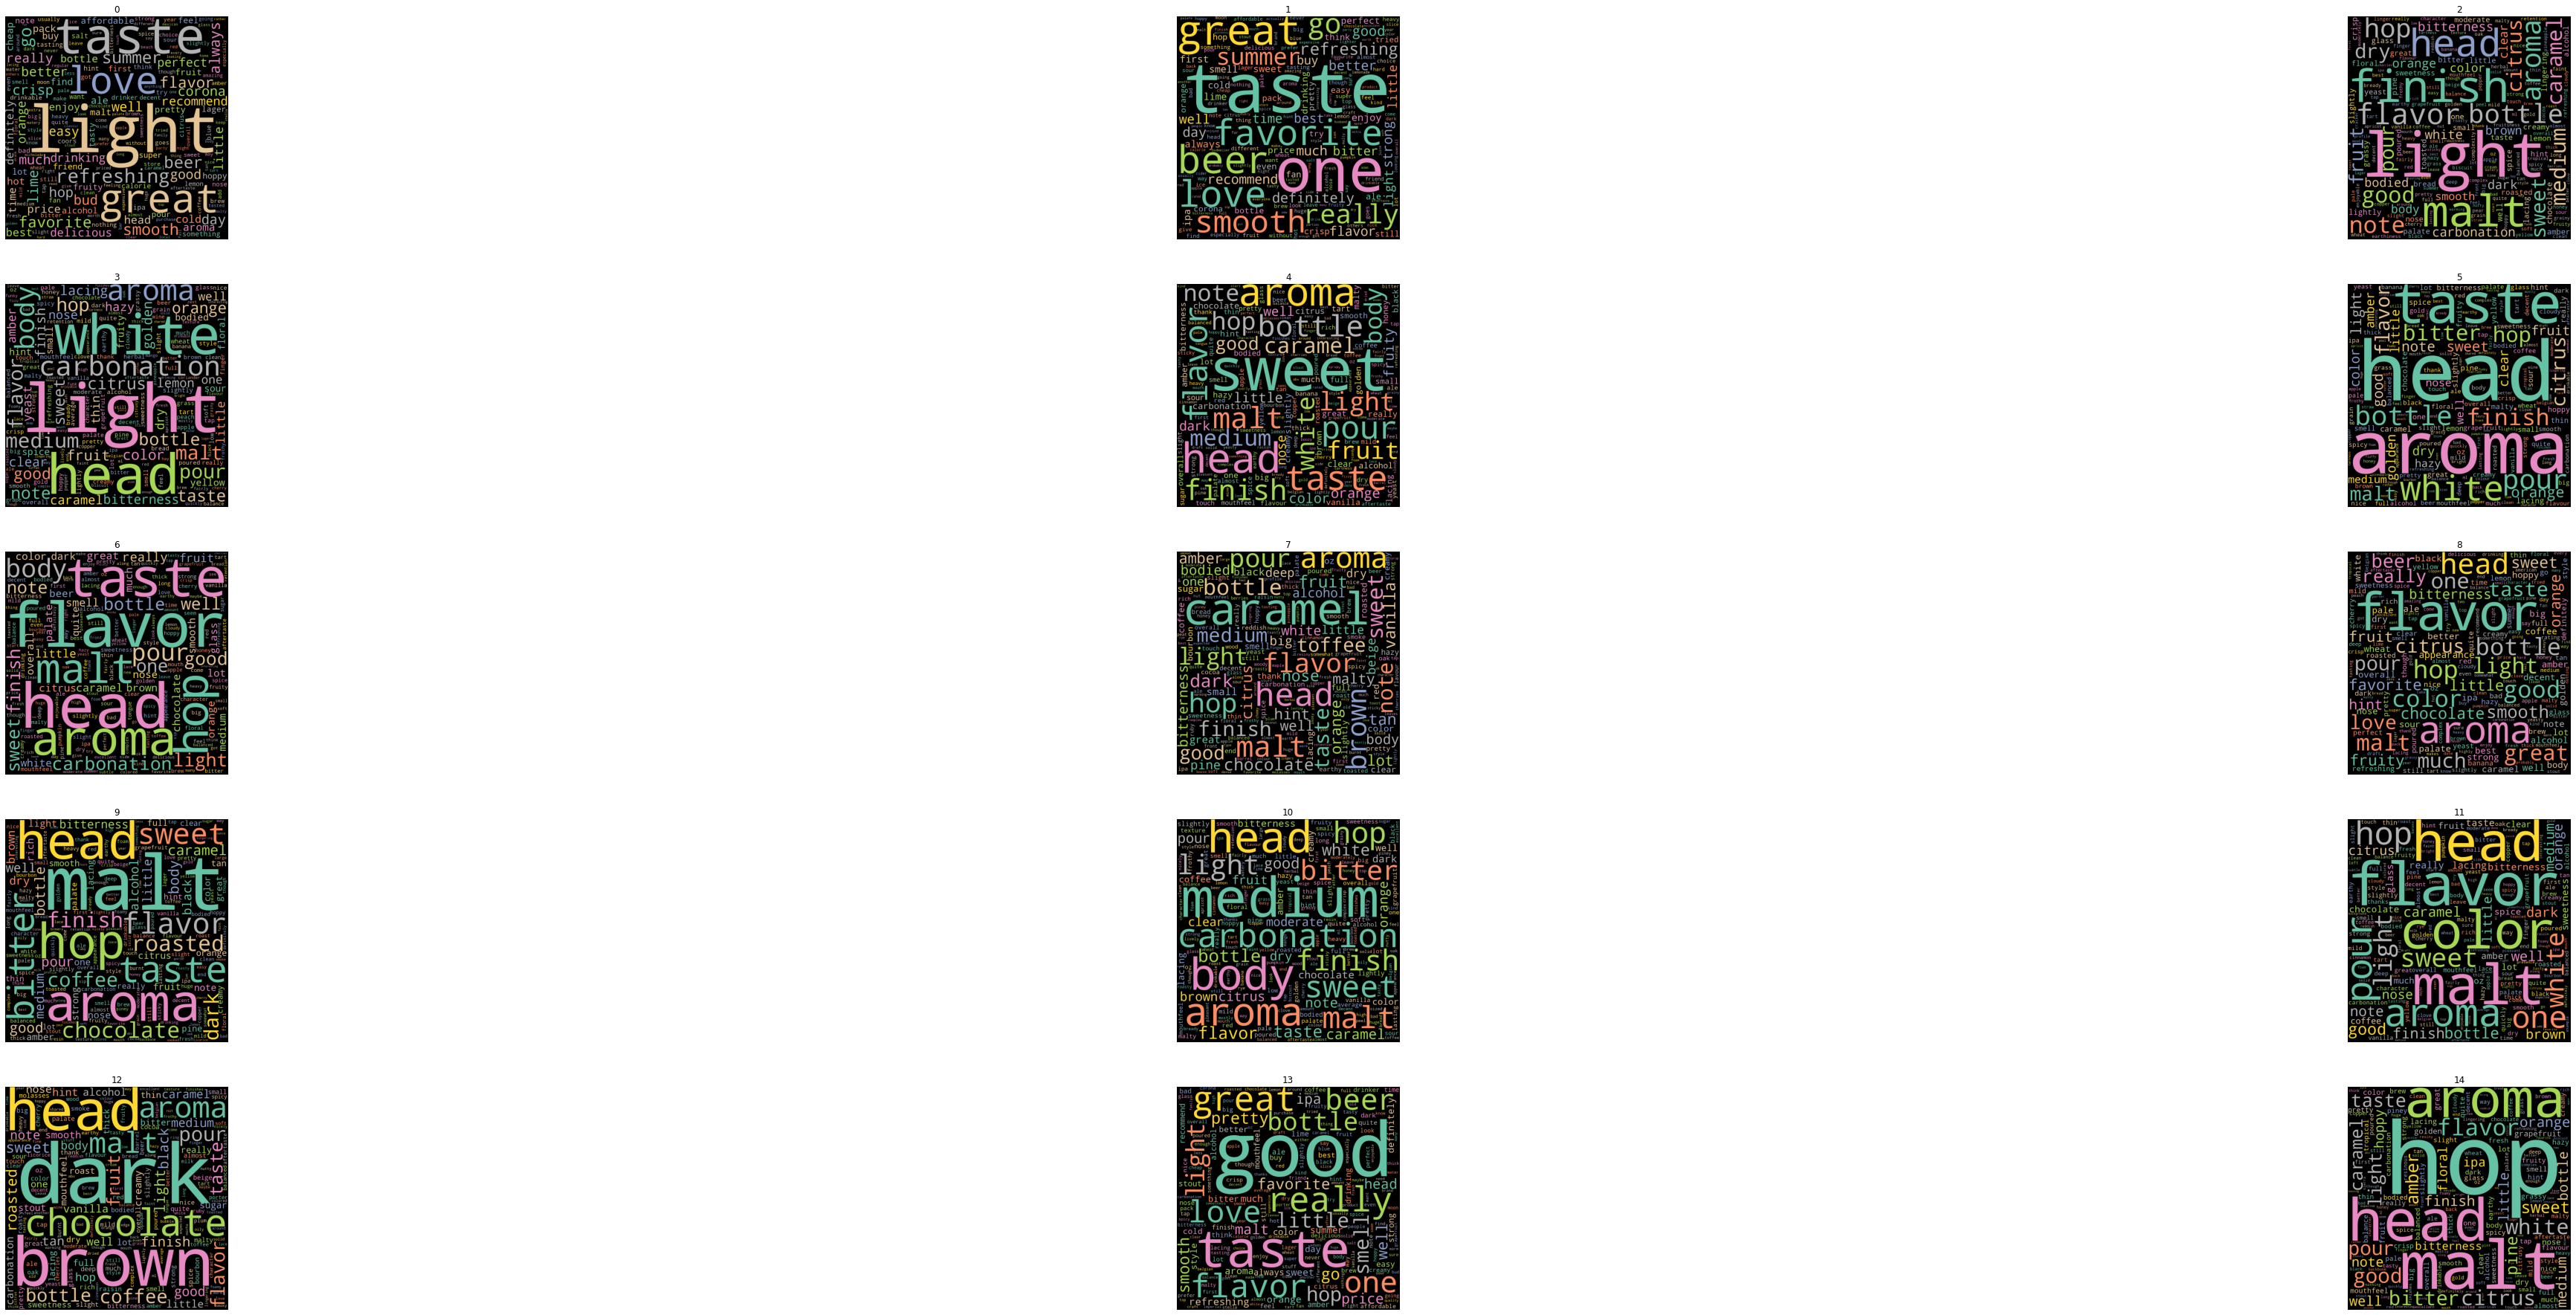

In [ ]:
fig = plt.figure(figsize=(80,32))
for i in range(n_topics):
    ax = fig.add_subplot(5,3,i+1)
    topic = i
    text = ' '.join(df.loc[df['topic']==i,'processed_text'].values)
    wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='Black',
                   colormap='Set2',
                   collocations=False).generate(text)
    ax.imshow(wc)
    ax.set_title(topic)
    ax.axis("off");

In [ ]:
topic_list = []
for topic_idx, topic in enumerate(model_lda.components_):
    top_n = [feature_names[i]
              for i in topic.flatten().argsort()[::-1][:10]]
    
    top_features = ' '.join(top_n)

top_features

'hops head malt aroma white bitter pours color finish flavor'

In [ ]:
ss29672_attributes = pd.DataFrame(columns=['id', 'attributes'])
ss29672_attributes['id'] = range(1, len(data)+1)
ss29672_attributes['attributes'] = df['attribute']

ss29672_attributes.head()

id attributes
0   1       hops
1   2       hops
2   3      aroma
3   4      aroma
4   5       hops

In [ ]:
ss29672_top10 = pd.DataFrame(columns = ['top10'])
ss29672_top10['top10'] = top_n

ss29672_top10

top10
0    hops
1    head
2    malt
3   aroma
4   white
5  bitter
6   pours
7   color
8  finish
9  flavor

In [ ]:
ss29672_attributes.to_csv('/content/drive/MyDrive/ADS Hackathon/ss29672_attributes.csv')
ss29672_top10.to_csv('/content/drive/MyDrive/ADS Hackathon/ss29672_top10.csv')

# Question 4

## Brand Level Analysis

In [ ]:
def map_sentiment(rating):
    if(int(rating)==3):
        return 2
    elif(int(rating)<3):
        return 3
    else:
        return 1 
  
  
df['review_sentiments']=[map_sentiment(s) for s in df['rating']]

In [ ]:
ids=df['brand'].value_counts()
ids=[ids.index[i] for i in range(len(ids))]

In [ ]:
data0=df[df['brand']==ids[0]]
data1=df[df['brand']==ids[1]]
data2=df[df['brand']==ids[2]]
data3=df[df['brand']==ids[3]]
data4=df[df['brand']==ids[4]]
df2=pd.concat([data0,data1,data2,data3,data4])
df2.head()

id                                            content  \
294  399  I typically cannot stand hoppy beers like IPA ...   
366  501  Amazing quality for the price . Sierra Nevada ...   
370  507  Great beer . I love ipa . And sierra Nevada is...   
391  537  I am not a fan of light beer in general . Do i...   
464  638  there is no going wrong when you purchase Sier...   

                    date                                            product  \
294  2017-10-09 04:00:00                      sierra-nevada-celebration-ipa   
366  2018-02-06 18:40:00  sierra-nevada-torpedo-extra-ipa-beer-6pk12-fl-...   
370  2015-12-01 21:51:00  sierra-nevada-torpedo-extra-ipa-beer-6pk12-fl-...   
391  2019-09-26 17:48:00                           sierra-nevada-summerfest   
464  2017-02-01 20:39:00                        sierra-nevada-pale-ale-beer   

             brand  rating         review_date  \
294  Sierra Nevada     2.0 2017-10-09 04:00:00   
366  Sierra Nevada     4.0 2018-02-06 18:40:00   
370  Sierra Nevada     4.0 2015-12-01 21:51:00   
391  Sierra Nevada     2.0 2019-09-26 17:48:00   
464  Sierra Nevada     5.0 2017-02-01 20:39:00   

                                          comment_text  \
294  i typically cannot stand hoppy beers like ipa ...   
366  amazing quality for the price sierra nevada is...   
370  great beer i love ipa and sierra nevada is rig...   
391  i am not a fan of light beer in general do if ...   
464  there is no going wrong when you purchase sier...   

                                              keywords  \
294  [typically, cannot, stand, hoppy, beer, ipa, a...   
366  [amazing, quality, price, sierra, nevada, far,...   
370  [great, love, ipa, sierra, nevada, right, best...   
391  [fan, light, general, light, take, review, gra...   
464  [going, wrong, purchase, sierra, nevada, pale,...   

                                                labels  review_sentiments  
294  [Palate, Brewing Process, Temperature State, B...                  3  
366  [Acidity, Palate, Brewing Process, Temperature...                  1  
370  [Palate, Brewing Process, Temperature State, B...                  1  
391  [Acidity, Palate, Brewing Process, Temperature...                  3  
464   [Temperature State, Brewing Process, Beer Style]                  1

In [ ]:
sent_dict={3:'Negative',2:'Neutral',1:'Positive'}
df2['sentiments']=[sent_dict[int(i)] for i in df2['review_sentiments'].values]


pos_batch=" ".join(list(df2[df2['review_sentiments']==1]['content']))
neg_batch=" ".join(list(df2[df2['review_sentiments']==3]['content']))

In [ ]:
br = BeerReviewKeywords()
br.get_trending_keywords(df2, 10)

{'negative': ['marshmallow',
  'burger',
  'whiskey',
  'alcoholic',
  'apricot',
  'yeasty',
  'vintner',
  'wine',
  'soda',
  'lemonade'],
 'positive': ['chocolateish',
  'yeasty',
  'peppercorn',
  'grapefruity',
  'hazelnut',
  'lemongrass',
  'cognac',
  'liquorice',
  'lemonade',
  'lasagna']}

In [ ]:
trending=pd.DataFrame(columns=['id','positive_keywords','negative_keywords'])
review_ids=[]
positive_keywords=[]
negative_keywords=[]
br=BeerReviewKeywords()

for i in range(10):
    data=df[df['brand']==ids[int(i)]].sort_values(by=['review_date'])
    keywords=br.get_trending_keywords(data,num_keywords=10)
    review_ids.append(ids[int(i)])
    positive_keywords.append(keywords['positive'])
    negative_keywords.append(keywords['negative'])
trending['id']=review_ids
trending['positive_keywords']=positive_keywords
trending['negative_keywords']=negative_keywords

In [ ]:
trending

id                                  positive_keywords  \
0  Sierra Nevada  [buttered, tea, raspberries, grapefruity, vani...   
1   Samuel Adams  [citrusy, apricot, tastebud, hazelnut, vanilla...   
2         Bell's  [syruppy, chocolateish, raspberry, cinnamon, g...   
3    New Belgium  [wine, buttery, iphone, apricot, watermelon, v...   
4     New Glarus  [peppercorn, applejuice, vanilla, chocolatey, ...   
5       Terrapin  [barleywines, brewers, citrus, syrupy, pineapp...   
6         Corona  [drunk, burger, taco, salsa, sunny, lemon, tas...   
7    Leinenkugel  [lager, tulip, pineapple, drinkable, tasty, dr...   
8      Blue Moon  [rich, vodka, creaminess, steak, tasty, garlic...   
9        Elysian  [tulip, yeast, espresso, gingerbread, grapefru...   

                                   negative_keywords  
0  [citrus, syrupy, liquors, peppery, tea, pineap...  
1  [buttery, tea, lemonade, peppery, flavorful, l...  
2  [oily, biscuity, coffee, vinegar, apricot, van...  
3  [drinkability, wine, resinous, spicyness, cara...  
4  [cherry, fridge, tangy, lager, corn, soda, sou...  
5  [cream, alcoholic, wine, carbonated, soapy, te...  
6  [occasionally, free, disappointed, kick, skunk...  
7  [marshmallowy, wine, hotdog, blueberry, tea, y...  
8  [amber, candyish, coffee, butter, drinkability...  
9  [brewer, apple, lagerboys, herbal, butter, per...

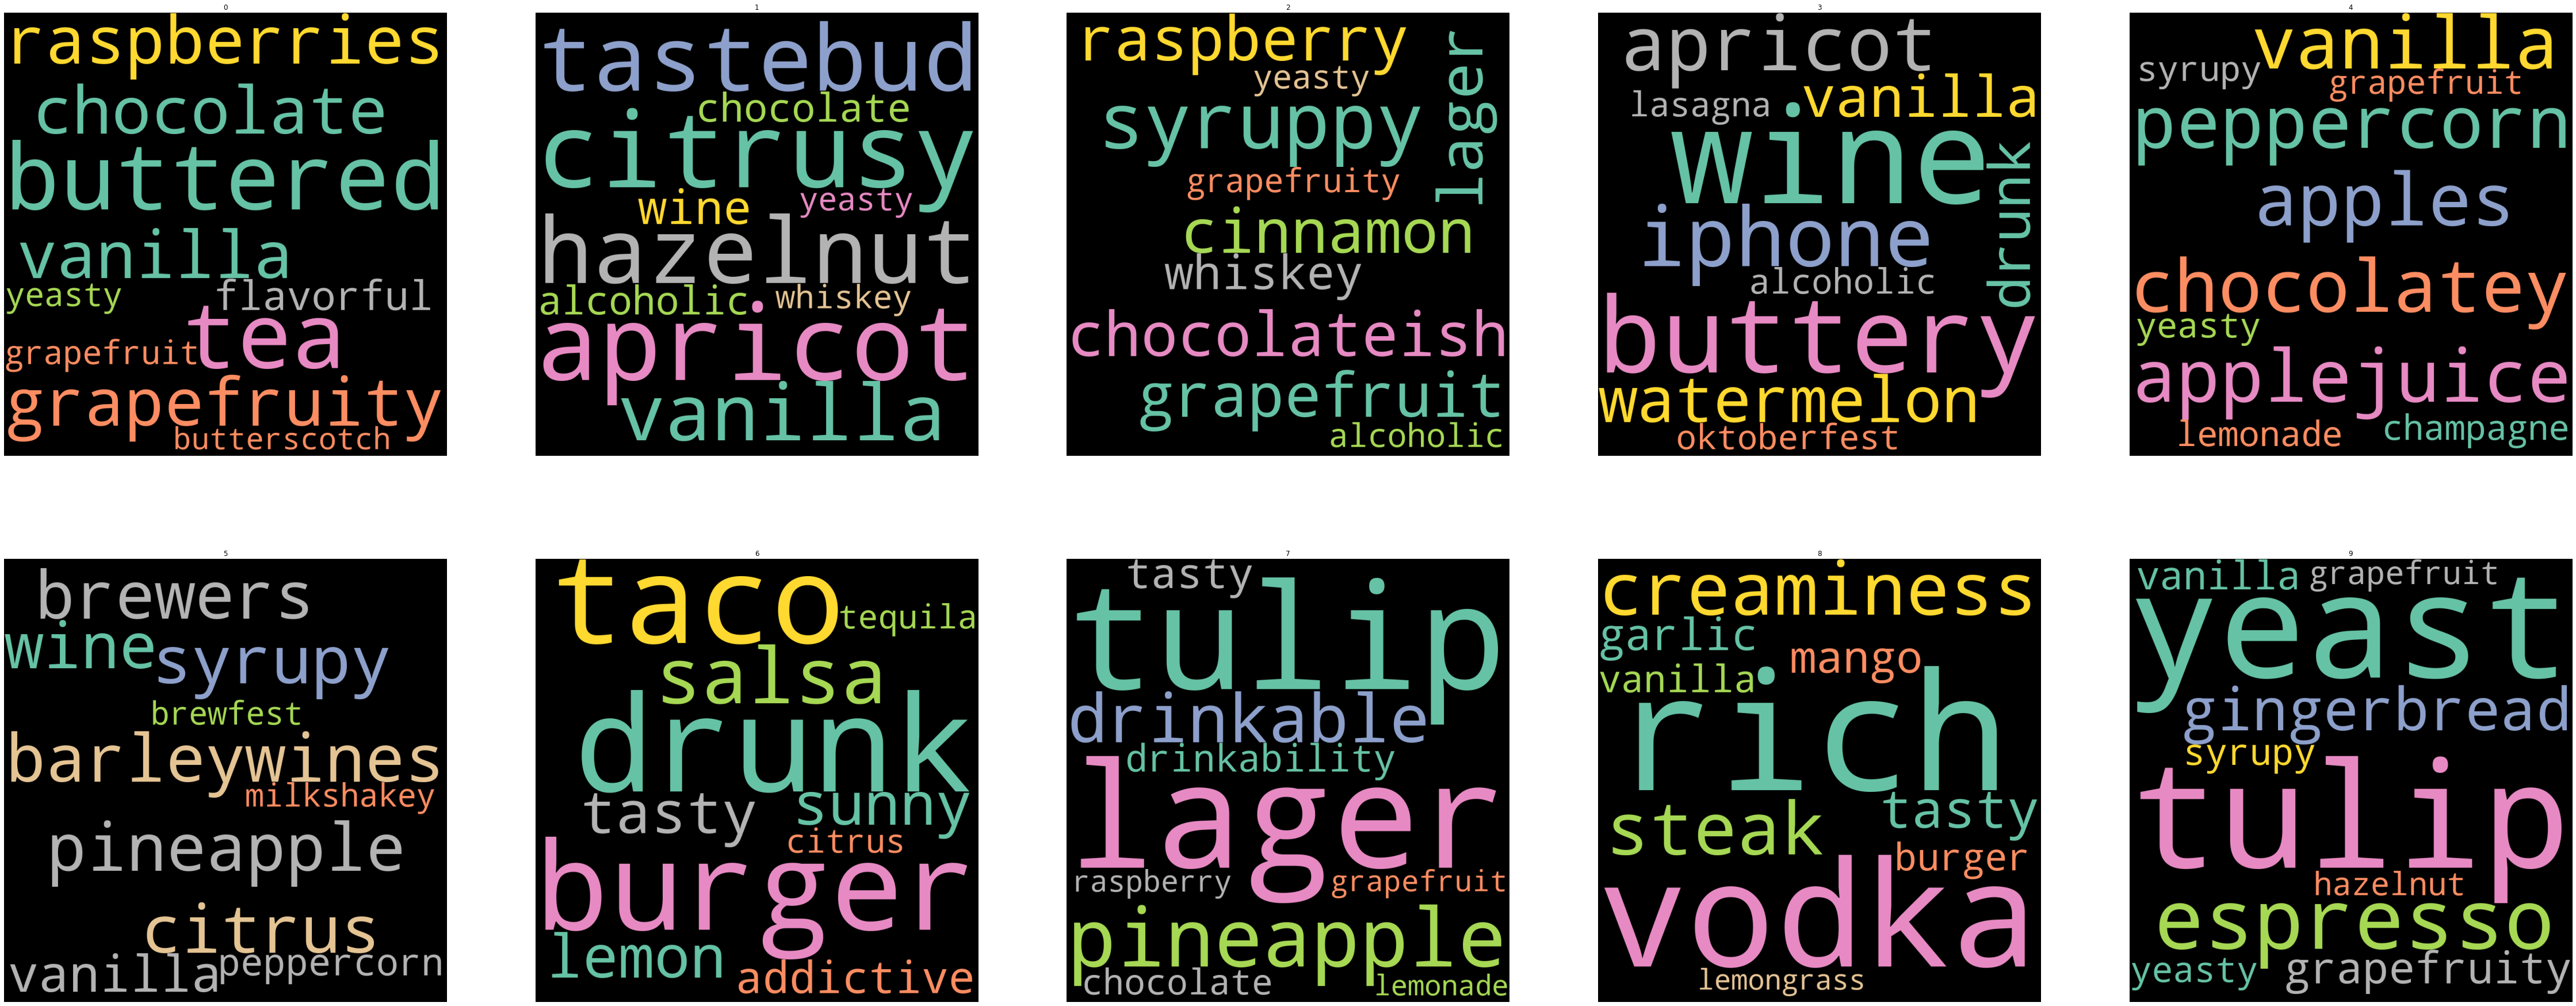

In [ ]:
fig = plt.figure(figsize=(80,32))
for i, j in enumerate(trending['id']):
    ax = fig.add_subplot(2,5,i+1)
    topic = i
    text = ' '.join(trending.loc[trending['id']==j,'positive_keywords'].apply(lambda x: ' '.join(x)))
    wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='Black',
                   colormap='Set2',
                   collocations=False).generate(text)
    ax.imshow(wc)
    ax.set_title(topic)
    ax.axis("off");

## Product Level Analysis

In [ ]:
ids=df['product'].value_counts()
ids=[ids.index[i] for i in range(len(ids))]

In [ ]:
data0=df[df['product']==ids[0]]
data1=df[df['product']==ids[1]]
data2=df[df['product']==ids[2]]
data3=df[df['product']==ids[3]]
data4=df[df['product']==ids[4]]
df2=pd.concat([data0,data1,data2,data3,data4])
df2.head()

id                                            content  \
3    4  Our go to beer at home ! We always pick up a p...   
49  66  Probably the only beer I can sit down an drink...   
62  85  I find Corona as an easy beer to drink , defin...   
63  86  This beer is ok . it is unfortunate that you n...   
67  91  I will only drink this if included in a Mexica...   

                   date       product   brand  rating         review_date  \
3   2017-05-05 10:32:00  corona-extra  Corona     5.0 2017-05-05 10:32:00   
49  2018-04-07 19:25:00  corona-extra  Corona     5.0 2018-04-07 19:25:00   
62  2017-10-07 05:00:00  corona-extra  Corona     4.0 2017-10-07 05:00:00   
63  2017-10-06 02:34:00  corona-extra  Corona     3.0 2017-10-06 02:34:00   
67  2021-09-12 05:41:00  corona-extra  Corona     3.0 2021-09-12 05:41:00   

                                         comment_text  \
3   our go to beer at home we always pick up a pac...   
49  probably the only beer i can sit down an drink...   
62  i find corona as an easy beer to drink definit...   
63  this beer is ok it is unfortunate that you nee...   
67  i will only drink this if included in a mexica...   

                                             keywords  \
3   [home, always, pick, pack, corona, grocery, st...   
49  [probably, sit, delicious, easily, pared, meal...   
62  [find, corona, easy, definitely, preferred, li...   
63  [ok, unfortunate, need, add, lime, wedge, rid,...   
67  [included, mexican, bulldog, otherwise, would,...   

                                               labels  review_sentiments  
3   [Palate, Brewing Process, Temperature State, B...                  1  
49  [Brewing Process, Palate, Price, Temperature S...                  1  
62  [Palate, Brewing Process, Temperature State, A...                  1  
63  [Brewing Process, Palate, Price, Temperature S...                  2  
67  [Brewing Process, Palate, Price, Temperature S...                  2

In [ ]:
sent_dict={3:'Negative',2:'Neutral',1:'Positive'}
df2['sentiments']=[sent_dict[int(i)] for i in df2['review_sentiments'].values]


pos_batch=" ".join(list(df2[df2['review_sentiments']==1]['content']))
neg_batch=" ".join(list(df2[df2['review_sentiments']==3]['content']))

In [ ]:
review_counts = df2.groupby(by=['product']).count()
review_counts

id  content  date  brand  \
product                                                                         
blue-moon-belgian-white-ale-beer-6-pack-12-fl-o...   89       89    89     89   
corona-extra                                        138      138   138    138   
corona-light-mexican-import-beer                     61       61    61     61   
pabst-blue-ribbon-beer-24pk12-fl-oz-cans             51       51    51     51   
stella-artois-lager-beer-18pk112-fl-oz-bottles       69       69    69     69   

                                                    rating  review_date  \
product                                                                   
blue-moon-belgian-white-ale-beer-6-pack-12-fl-o...      89           89   
corona-extra                                           138          138   
corona-light-mexican-import-beer                        61           61   
pabst-blue-ribbon-beer-24pk12-fl-oz-cans                51           51   
stella-artois-lager-beer-18pk112-fl-oz-bottles          69           69   

                                                    comment_text  keywords  \
product                                                                      
blue-moon-belgian-white-ale-beer-6-pack-12-fl-o...            89        89   
corona-extra                                                 138       138   
corona-light-mexican-import-beer                              61        61   
pabst-blue-ribbon-beer-24pk12-fl-oz-cans                      51        51   
stella-artois-lager-beer-18pk112-fl-oz-bottles                69        69   

                                                    labels  review_sentiments  \
product                                                                         
blue-moon-belgian-white-ale-beer-6-pack-12-fl-o...      89                 89   
corona-extra                                           138                138   
corona-light-mexican-import-beer                        61                 61   
pabst-blue-ribbon-beer-24pk12-fl-oz-cans                51                 51   
stella-artois-lager-beer-18pk112-fl-oz-bottles          69                 69   

                                                    sentiments  
product                                                         
blue-moon-belgian-white-ale-beer-6-pack-12-fl-o...          89  
corona-extra                                               138  
corona-light-mexican-import-beer                            61  
pabst-blue-ribbon-beer-24pk12-fl-oz-cans                    51  
stella-artois-lager-beer-18pk112-fl-oz-bottles              69

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

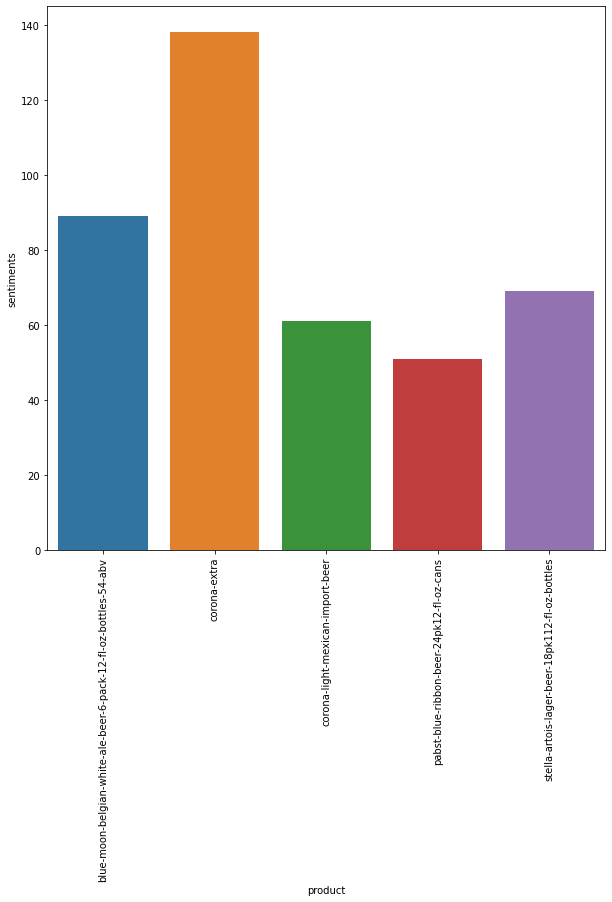

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x = review_counts.index, y = review_counts['sentiments'])
plt.xticks(rotation = 90) 